# Precipitation Forecasting using Recurrent Neural Networks

In this Notebook, we investigate Recurrent Neural Networks (RNNs) as a model to forecast precipitation. RNNs are specialized neural architectures designed to capture temporal dependencies by maintaining a form of internal memory across sequential inputs. Compared to traditional feedforward neural networks, RNNs leverage hidden states that persist information about previous time steps, making them particularly suitable for weather-related forecasts where past conditions influence future outcomes. 

## 0. Imports and Basic Setup

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-01-02 19:59:24.028376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 19:59:24.036685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:59:24.104648: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:59:24.167348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735844364.232036  170755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735844364.24

## 1. Load Preprocessed Train, Validation, and Test Splits


In [2]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for RNN

We'll create a function that, for each partition (train/val/test), generates sequences of length seq_length to predict prec on the "next" day. For example, X[t : t+seq_length] -> y[t+seq_length].

Important: Because data comes from multiple locations, the simplest approach is to do it location by location to avoid "splicing" between location boundaries. 

In [3]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    For each location independently, create sequences of length seq_length
    to predict the (seq_length+1)-th day's target_col.
    Returns:
        X: np.array of shape (num_samples, seq_length, num_features)
        y: np.array of shape (num_samples,)
    """
    X_list, y_list = [], []
    
    # Group by location so we don't mix data across different basins
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)  # reindex after grouping

        # Convert to numpy for slicing
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        # Slide over the time dimension for that location
        for i in range(len(loc_df) - seq_length):
            X_list.append(loc_features[i : i + seq_length])
            y_list.append(loc_target[i + seq_length])

    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

## 3. Define Features and Target

We use "prec" as the target. Let's use *all other numeric columns* from the preprocessed data as potential features, except for location / date info.

In [4]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate Sequence Datasets


In [5]:
SEQ_LENGTH = 30

X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202420, 30, 21) (1202420,)
Validation sequence shape: (106720, 30, 21) (106720,)
Test sequence shape: (106620, 30, 21) (106620,)


## 5. Build a Simple RNN Model in Keras

Here, we’ll build a straightforward RNN with one SimpleRNN layer and a Dense output.

In [6]:
model = keras.Sequential([
    layers.SimpleRNN(units=64, activation='relu', input_shape=(SEQ_LENGTH, len(feature_cols))),
    layers.Dense(1)  # output for a single regression target
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

2025-01-02 19:59:57.750940: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/florian/miniconda3/envs/amitecc2/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [7]:
BATCH_SIZE = 256
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.8098 - mae: 0.5683 - val_loss: 0.8257 - val_mae: 0.5661
Epoch 2/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.7456 - mae: 0.5366 - val_loss: 0.8232 - val_mae: 0.5646
Epoch 3/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.7246 - mae: 0.5290 - val_loss: 0.8198 - val_mae: 0.5622
Epoch 4/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.7113 - mae: 0.5243 - val_loss: 0.8217 - val_mae: 0.5462
Epoch 5/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.6968 - mae: 0.5199 - val_loss: 0.8306 - val_mae: 0.5522
Epoch 6/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.6821 - mae: 0.5165 - val_loss: 0.8284 - val_mae: 0.5592
Epoch 7/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.6815 - mae: 0.5164 - val_loss: 0.8249 - val_mae: 0.5591
Epoch 8/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.6772 - mae: 0.5144 - val_loss: 0.8283 - val_mae: 0.5468
Epoch 9/10
4697/4697 ━━━━━━━━━━━

## 7. Evaluate the Model

In [8]:
val_preds = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Evaluate on test set
test_preds = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

3335/3335 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step
Validation MSE:  0.8172
Validation RMSE: 0.9040
Validation MAE:  0.5517
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 770us/step
Test MSE:  0.8031
Test RMSE: 0.8961
Test MAE:  0.5564


## 8. Plot Training History

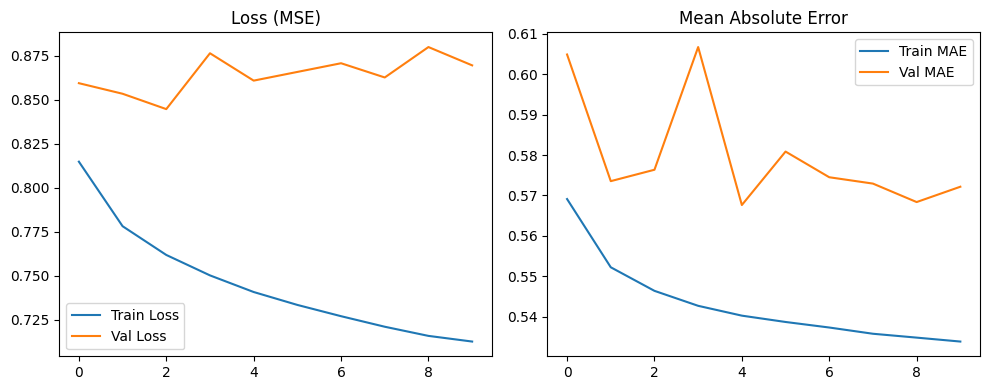

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (MSE)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()

## 9. Quick Prediction Visualization


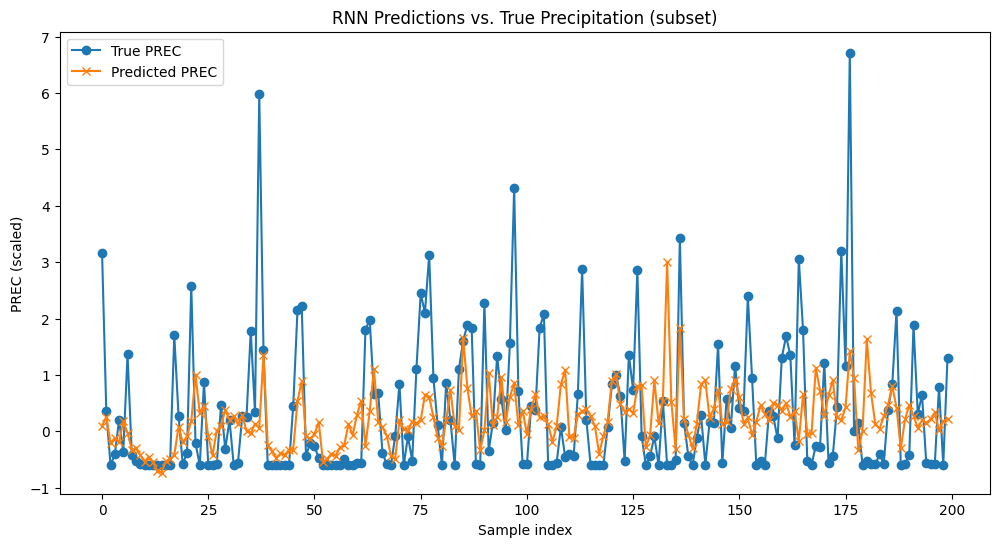

In [12]:
num_samples_to_plot = 200  # just pick some small subset 
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("RNN Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 10. Feature Importance Study

To investigate feature importance in the RNN, we use a permutation importance approach.

The idea is to:
* Compute a baseline metric (e.g. MSE) using the unshuffled test data.
* For each feature in the input set, shuffle (i.e. randomly permute) just that one feature across all test samples (keeping other features intact).
* Run inference on this shuffled data and measure the new metric.
* The increase in error (Δ MSE) compared to the baseline is treated as an indicator of that feature’s importance.

This approach is model-agnostic and commonly used for neural networks such as RNNs.

3332/3332 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step
Baseline Test MSE: 0.8402
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 753us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 769us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 771us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 773us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 754us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 762us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 767us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 778us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 780us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 776us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 774us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 783us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 772us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 763us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 772us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 772us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 764us/step
3332/3332 ━━━━━━━━━━━━━━━━━━━━ 3s 772us/step
Feature Importances (Permutat

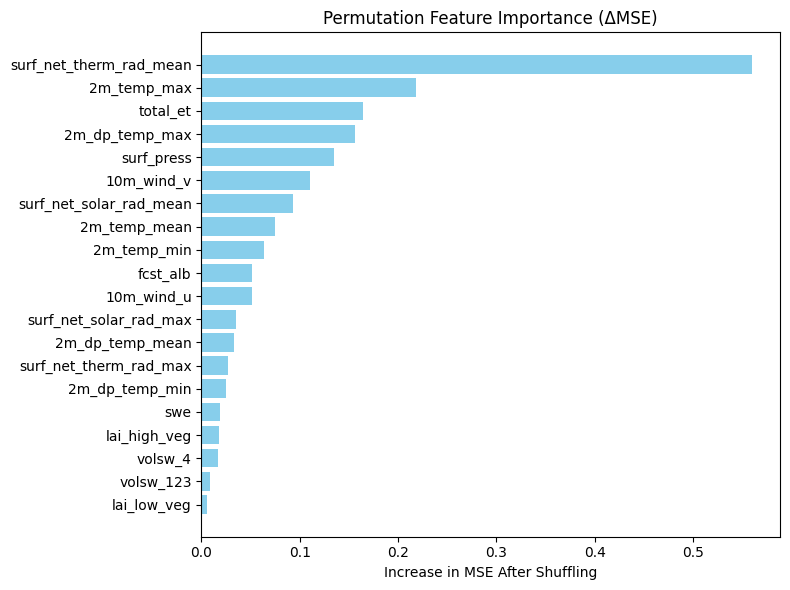

In [13]:
baseline_preds = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_preds)
print(f"Baseline Test MSE: {baseline_mse:.4f}")

def permutation_importance(model, X, y, baseline_mse):
    """
    For each feature, shuffle it across the dataset, compute new MSE, 
    and measure the difference from baseline_mse. 
    Returns:
       dict { feature_name: delta_mse }
    """
    feature_importances = {}
    X_copy = np.copy(X) 
    
    num_features = X.shape[-1]  # last dimension = number of features
    for f_idx in range(num_features):
        # Shuffle only the f_idx-th feature
        shuffled = np.copy(X_copy)
        np.random.shuffle(shuffled[:, :, f_idx])  # shuffle in-place across the sample dimension
        
        # Predict with the permuted data
        perm_preds = model.predict(shuffled)
        perm_mse = mean_squared_error(y, perm_preds)
        
        delta_mse = perm_mse - baseline_mse
        feature_name = feature_cols[f_idx]
        feature_importances[feature_name] = delta_mse
    
    return feature_importances

importances_dict = permutation_importance(model, X_test, y_test, baseline_mse)

sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (Permutation-based), sorted by ΔMSE:")
for feat, imp in sorted_importances:
    print(f"Feature: {feat:<30} | ΔMSE: {imp:.6f}")

plt.figure(figsize=(8, 6))
feat_names = [x[0] for x in sorted_importances]
deltas = [x[1] for x in sorted_importances]
plt.barh(feat_names, deltas, color='skyblue')
plt.title("Permutation Feature Importance (ΔMSE)")
plt.xlabel("Increase in MSE After Shuffling")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()